# Data Cleaning and Visualisation
This is notebook contains the data cleaning and visualisation procedures of the projcet. The data is downloaded as a list of urls (`ParquetFilesUrls.csv`) from the [EEA Air Quality Download Service](https://eeadmz1-downloads-webapp.azurewebsites.net/) with the following filters:
* Country: Finland
* Cities: Helsinki, Jyvaskyla, Lahti, Kuopio, Oulu, Tampere, Turku
* Pollutants ([EU Directive 2008/05/EC](https://eur-lex.europa.eu/legal-content/EN/TXT/?uri=CELEX%3A32008L0050)): SO2, NOy, CO, C6H6 (benzene), PM10, PM2.5, Pb, O3 
* Dataset: Up to date data (E2a)
* Type: Hourly Data
* Temporal coverage: 1/01/2025 - 2/01/2025
* Download format: List of Urls

In [36]:
%matplotlib widget
import os, geopandas, folium, requests, matplotlib, folium.plugins, branca
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

### 1. Data preprocessing 

1.1.1 Read air pollution data <br>
Read urls to each parquet file in `ParquetFilesUrls.csv`. <br>
NOTE: The `ParquetFilesUrls.csv` has links to parquet files that contain data outside our specified range. According to [EEA Air Quality Download Service](https://eeadmz1-downloads-webapp.azurewebsites.net/): 
> For performance reasons, the list of URLs is not limited by the Temporal Coverage or Type you might have selected. That is, the list of URLs will potentially contain dates and types outside the range specified.

So the data will be filtered later according to the date range of 01/01/2025 to 02/01/2025

In [37]:
DATA_CSV_E2A = r"data\Air pollution data\FI_SE_DK_NO_EE_IS_IE_LT\ParquetFilesUrls.csv"    # Path to e2a csv data with urls
DATA_CSV_E1A = r"data\Air pollution data\FI_SE_DK_NO_EE_IS_IE_LT\ParquetFilesUrlse1a.csv" # Path to e1a csv with data urls

DATA_DIR = r"data\Air pollution data\FI_SE_DK_NO_EE_IS_IE_LT"                               # Folder with parquet files
METADATA_DIR = r"data\Air pollution data\metadata\AirQualityStation.csv"

# START_DATE = "2025-10-1"
# END_DATE = "2025-10-8" 

START_DATE = (datetime.today() - timedelta(days=7)).strftime('%Y-%m-%d') # 7 days before today
END_DATE = datetime.today().strftime('%Y-%m-%d')

POLLUTANTS = ["SO2", "NOy", "CO", "C6H6", "PM10", "PM2.5", "Pb", "O3"]

HELSINKI_GPS = (60.1699, 24.9384)

In [38]:
# Use url requests to download the parquet files into local directory
urls = pd.read_csv(DATA_CSV_E2A)["ParquetFileUrl"]
# urls = pd.concat([urls, pd.read_csv(DATA_CSV_E1A)["ParquetFileUrl"]]) # Uncomment to include E1A data

for url in urls:
    fileName = url.split("/")[-1]
    with open(f"{DATA_DIR}/{fileName}", "wb") as fp:
        fp.write(requests.get(url).content)

In [39]:
# Read the locally stored parquet files into Dataframe
dir_data_full = os.path.join(os.getcwd(), DATA_DIR)

columns_air = ["Samplingpoint","Pollutant","Start","Value", "Unit", "Validity"]

df_air = pd.DataFrame()

for root, _, files in os.walk(dir_data_full): # scans through data directory recursively
    for filename in files:
        if not filename.endswith(".parquet"):
            continue
        data = pd.read_parquet(os.path.join(root, filename), columns=columns_air)
        df_air = pd.concat([df_air, data])

print(df_air.head())
df_air.describe()

              Samplingpoint  Pollutant               Start  \
0  DK/SPO-DK0034A_00001_100          1 2025-01-01 00:00:00   
1  DK/SPO-DK0034A_00001_100          1 2025-01-01 01:00:00   
2  DK/SPO-DK0034A_00001_100          1 2025-01-01 02:00:00   
3  DK/SPO-DK0034A_00001_100          1 2025-01-01 03:00:00   
4  DK/SPO-DK0034A_00001_100          1 2025-01-01 04:00:00   

                  Value    Unit  Validity  
0  1.860000000000000000  ug.m-3         1  
1  0.840000000000000000  ug.m-3         1  
2  1.420000000000000000  ug.m-3         1  
3  0.960000000000000000  ug.m-3         1  
4                 0E-18  ug.m-3       -99  


,Pollutant,Start,Validity
count,1.915116e+06,1915116,1.915116e+06
mean,1.844496e+03,2025-05-23 10:31:34.803030016,5.259770e-01
min,1.000000e+00,2024-12-31 23:00:00,-9.900000e+01
25%,5.000000e+00,2025-03-13 23:00:00,1.000000e+00
50%,7.000000e+00,2025-05-23 08:00:00,1.000000e+00
75%,6.001000e+03,2025-08-02 16:00:00,1.000000e+00
max,6.001000e+03,2025-10-12 22:00:00,4.000000e+00
std,2.764647e+03,NaN,5.417723e+00


1.1.2 Clean air pollution data. <br>
Notice the Finnish air pollution stations only have readings for PM2.5 (id 6001), PM10 (id 5), SO2 (id 1) and O3 (id 7), not the entire list of pollutants that we filtered for from the EEA Air Quality download service.

In [41]:
map_id_to_pollutant = {
    1: "SO2",
    5: "PM10",
    6: "NOy",
    7: "O3",
    10: "CO",
    20: "C6H6",
    6001: "PM2.5"
}

df_air["Start"] = pd.to_datetime(df_air["Start"])
df_air = df_air[(df_air["Start"] >= START_DATE) & \
                (df_air["Start"] <= END_DATE)]                  # Filter to a smaller range of dates

print("Num of records BEFORE filtering:", len(df_air))

df_air["Samplingpoint"] = df_air["Samplingpoint"].str[3:]       # Remove country code prefix

df_air = df_air[(df_air["Validity"] == 1) | (df_air["Validity"] == 4)]  # Delete invalid values
df_air = df_air.drop(["Validity"], axis=1)                      # Validity column is now useless

df_air["Value"] = df_air["Value"].astype(float)
df_air["Value"] = df_air["Value"].where(lambda x: x>0, np.nan)  # Replace negative values with nan
df_air["Value"] = df_air["Value"].ffill()                       # forward fill null values

print("Num of records AFTER filtering:", len(df_air))

series_summary = df_air["Pollutant"].value_counts()
series_summary.index = series_summary.index.to_series().map(map_id_to_pollutant)
print(series_summary)

df_air.describe()

Num of records BEFORE filtering: 42982
Num of records AFTER filtering: 37264
Pollutant
PM10     13295
PM2.5    11261
O3        5611
SO2       3980
CO        2779
C6H6       338
Name: count, dtype: int64


,Pollutant,Start,Value
count,37264.000000,37264,37264.000000
mean,1817.344971,2025-10-08 05:31:29.555603456,11.547782
min,1.000000,2025-10-05 00:00:00,0.000002
25%,5.000000,2025-10-06 13:00:00,2.567000
50%,7.000000,2025-10-08 03:00:00,5.982755
75%,6001.000000,2025-10-09 20:00:00,12.513321
max,6001.000000,2025-10-12 00:00:00,136.845500
std,2753.205430,NaN,14.991393


EDA on distribution of air pollutants throughout the day

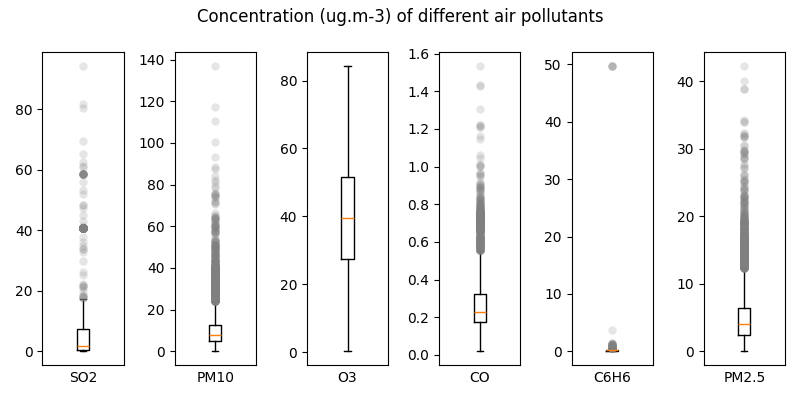

In [42]:
fig, axes = plt.subplots(1, len(df_air["Pollutant"].unique()), figsize=(8,4))
fig.suptitle("Concentration (ug.m-3) of different air pollutants")

for ax, (pollutant_id, data) in zip(axes.flatten(), df_air.groupby("Pollutant")):
    ax.boxplot(data["Value"], flierprops=dict(linewidth=0, markeredgecolor="none", markerfacecolor="grey", alpha=0.2))
    ax.set_xlabel(map_id_to_pollutant[pollutant_id])
    ax.set_xticks([]) # Remove useless xticks for each subplot

plt.tight_layout()
plt.show()

1.2 Obtain mapping of station to GPS coordinates <br>
The metadata file ([source](https://discomap.eea.europa.eu/App/AQViewer/index.html?fqn=Airquality_Dissem.b2g.measurements)), `AirQualityStation.csv`, has mapping of station ID (Sampling Point Id) to longitude and latitude coordinates. 

In [43]:
columns_metadata = ["Country", "Timezone", "Sampling Point Id", "Air Pollutant", "Longitude", "Latitude", "Air Quality Station Name"]
df_metadata = pd.read_csv(METADATA_DIR, usecols=columns_metadata)
df_metadata = df_metadata.drop_duplicates() # Duplicates due to station's new sampling processes
df_metadata

,Country,Timezone,Air Quality Station Name,Sampling Point Id,Air Pollutant,Longitude,Latitude
0,Andorra,UTC+01,Escaldes-Engordany,SPO-AD0942A-0001,SO2,1.53914,42.50969
1,Andorra,UTC+01,Escaldes-Engordany,SPO-AD0942A-0005,PM10,1.53914,42.50969
3,Andorra,UTC+01,Escaldes-Engordany,SPO-AD0942A-0007,O3,1.53914,42.50969
4,Andorra,UTC+01,Escaldes-Engordany,SPO-AD0942A-0008,NO2,1.53914,42.50969
5,Andorra,UTC+01,Escaldes-Engordany,SPO-AD0942A-0009,NOX as NO2,1.53914,42.50969
...,...,...,...,...,...,...,...
83303,Kosovo under UNSCR 1244/99,UTC+01,Mobile,SPO-XK00013_00008_100,NO2,21.13354,42.64652
83304,Kosovo under UNSCR 1244/99,UTC+01,Mobile,SPO-XK00013_00009_100,NOX as NO2,21.13354,42.64652
83305,Kosovo under UNSCR 1244/99,UTC+01,Mobile,SPO-XK00013_00010_100,CO,21.13354,42.64652
83306,Kosovo under UNSCR 1244/99,UTC+01,Mobile,SPO-XK00013_00038_100,NO,21.13354,42.64652


1.3 Read GIS data of Finland's border. Source: [simplemaps.com](https://simplemaps.com/gis/country/fi)

In [44]:
gdf_fi_border = geopandas.read_file(r"data\GIS data\borders\fi.shp")

helsinki_station_ids = df_air["Samplingpoint"].unique() 
df_coords = df_metadata[df_metadata["Sampling Point Id"].isin(helsinki_station_ids)]
gdf_coords = geopandas.GeoDataFrame(
        geometry=geopandas.points_from_xy(df_coords["Longitude"], df_coords["Latitude"]), crs=gdf_fi_border.crs)

1.4 Read GIS data of Finnish municipalities <br>
We can use this if we decide to focus on air pollution within Finland only.

In [45]:
gdf_fin_mun = geopandas.read_file(r"data\GIS data\FI municipalities\SuomenMaakuntajako_2025_10k.shp").to_crs(gdf_coords.crs)

### 2.Visualisation of pollutant concentrations

2.1 Merge air pollution data and station GPS coordinates. 

In [46]:
df_merged = pd.merge(df_air, df_metadata, left_on="Samplingpoint", right_on="Sampling Point Id", how="left", )
df_merged = df_merged.set_index("Start")
gdf_merged = geopandas.GeoDataFrame(
    data=df_merged,
    geometry=geopandas.points_from_xy(df_merged["Longitude"], df_merged["Latitude"]),
    crs=gdf_fi_border.crs
)
gdf_merged.head()

,Samplingpoint,Pollutant,Value,Unit,Country,Timezone,Air Quality Station Name,Sampling Point Id,Air Pollutant,Longitude,Latitude,geometry
Start,,,,,,,,,,,,
2025-10-05 00:00:00,SPO-DK0034A_00001_100,1,1.36,ug.m-3,Denmark,UTC+01,"""Copenhagen/1103""",SPO-DK0034A_00001_100,SO2,12.5711,55.6743,POINT (12.5711 55.6743)
2025-10-05 01:00:00,SPO-DK0034A_00001_100,1,1.25,ug.m-3,Denmark,UTC+01,"""Copenhagen/1103""",SPO-DK0034A_00001_100,SO2,12.5711,55.6743,POINT (12.5711 55.6743)
2025-10-05 02:00:00,SPO-DK0034A_00001_100,1,1.40,ug.m-3,Denmark,UTC+01,"""Copenhagen/1103""",SPO-DK0034A_00001_100,SO2,12.5711,55.6743,POINT (12.5711 55.6743)
2025-10-05 03:00:00,SPO-DK0034A_00001_100,1,1.44,ug.m-3,Denmark,UTC+01,"""Copenhagen/1103""",SPO-DK0034A_00001_100,SO2,12.5711,55.6743,POINT (12.5711 55.6743)
2025-10-05 04:00:00,SPO-DK0034A_00001_100,1,1.48,ug.m-3,Denmark,UTC+01,"""Copenhagen/1103""",SPO-DK0034A_00001_100,SO2,12.5711,55.6743,POINT (12.5711 55.6743)


2.2 Render map - pollution across time <br>
This focuses on sampling point SPO-FI00208 and shows the amount of pollution for each pollutant.

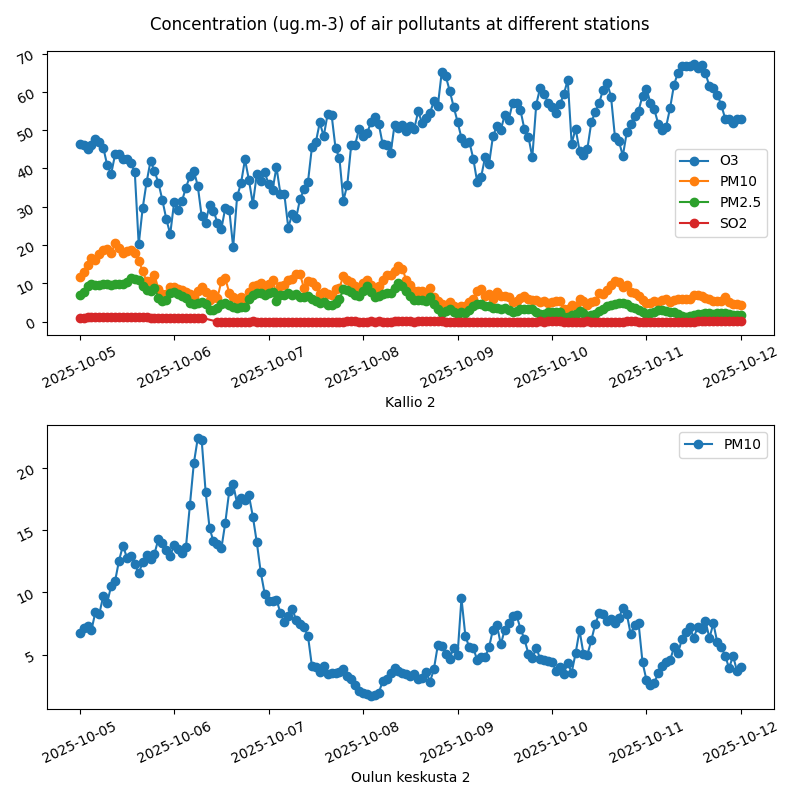

In [47]:
SAMPLING_POINTS = ["Kallio 2", "Oulun keskusta 2"]
filtered = gdf_merged[gdf_merged["Air Quality Station Name"].isin(SAMPLING_POINTS)]
filtered = filtered[["Value", "Air Pollutant", "Air Quality Station Name"]]

fig, axes = plt.subplots(2, 1, figsize=(8, 8))

for ax, sampling_point in zip(axes, SAMPLING_POINTS):
    data = filtered[filtered["Air Quality Station Name"] == sampling_point]
    labels = []
    
    for k, v in data.groupby("Air Pollutant"):
        ax.plot(v["Value"], marker="o")
        labels.append(k)

    ax.tick_params(rotation=25)
    ax.set_xlabel(sampling_point)
    ax.legend(labels)

fig.suptitle("Concentration (ug.m-3) of air pollutants at different stations")
plt.tight_layout()
plt.show()

2.3 Render map: pollution across locations<br>
`geopandas.explore()` uses the folium library to create interactive maps which can be saved as html. Notice how certain stations do not measure all the pollutants we specified

Create a mapping of pollutant concentration value to boundaries in a health index. Sources are [ETC HE Report 2024/17](https://www.eionet.europa.eu/etcs/etc-he/products/etc-he-products/etc-he-reports/etc-he-report-2024-17-eeas-revision-of-the-european-air-quality-index-bands/@@download/file/ETC%20HE%20Report%202024-17_Gonzalez%20Ortiz.pdf) (PM2.5, PM10, O3, NO2, SO2) and [EU Directive 2008/05/EC](https://eur-lex.europa.eu/legal-content/EN/TXT/?uri=CELEX%3A32008L0050) (C6H6, CO, Pb)

In [48]:
'''
Define colormaps to map pollution values directly to a health index
[Good,  Fair,   Moderate,   Poor,   Very Poor,  Extremely Poor]
[min,   green,  yellow,     red,    purple,     max]
'''
BOUNDARY_COLORS = ["green", "green", "yellow", "red", "purple", "purple"]

cmap_boundaries = {
    "PM2.5": [5, 11, 33, 71, 116,  140],
    "PM10": [15, 31, 83, 158, 233, 270],
    "O3": [60, 81, 111, 141, 171, 180],
    "NOy": [10, 18, 43, 81, 126, 150],
    "SO2": [20, 31, 83, 158, 233, 275],
    "CO": [0, 0, 5, 7, 10, 10],
    "Pb": [0, 0, 0.25, 0.35, 0.5],
    "C6H6": [0, 0, 2, 3.5, 5, 5]
}
cmaps = {
    pollutant: branca.colormap.LinearColormap(
        colors=BOUNDARY_COLORS, 
        index=boundaries,
        vmin=boundaries[0], vmax=boundaries[-1],
        caption=f"{pollutant} ug.m-3",
    )
    for pollutant, boundaries in cmap_boundaries.items()
}

In [ ]:
# If the interactive OpenStreetMap map does not render, restart VS code (or whatever viewer used)
m = gdf_fi_border.boundary.explore(name="Border")

folium.TileLayer("OpenStreetMap").add_to(m)

gdf_fin_mun.explore(
    m=m,
    color="yellow",
    name="Municipalities",
)

for pollutant in gdf_merged["Air Pollutant"].unique():
    gdf_pollutant = gdf_merged[gdf_merged["Air Pollutant"] == pollutant]
    gdf_pollutant.explore(
        m=m, 
        column="Value", 
        name=pollutant, 
        overlay=False,
        cmap=cmaps[pollutant],
        legend_kwds=dict(caption=pollutant), 
        marker_kwds=dict(radius=8, fill=True, stroke=False))
       

folium.LayerControl(collapsed=False).add_to(m)
m.save("interactive_map-select_pollutant.html") # Save map in html
m

2.4 Render map: Pollution across time with slider <br>

In [82]:
# Creates the timeslider map for the specified pollutant  
def makeTimeSliderMap(gdf_merged, pollutant:str, cmaps):
    
    gdf_pollutant = gdf_merged[gdf_merged["Air Pollutant"] == pollutant]
    cmap = cmaps[pollutant]
    gdf_pollutant["Colors"] = gdf_pollutant["Value"].apply(cmap)

    points = [
        {"time": str(index),
        "coordinates": [row["Longitude"], row["Latitude"]],
        "color": row["Colors"],
        "value": row["Value"],
        "Air quality station name": row["Air Quality Station Name"]}
        for index, row in gdf_pollutant.iterrows()
    ]

    features = [
        {
            "type": "Feature",
            "geometry": {
                "type": "Point",
                "coordinates": point["coordinates"],
            },
            "properties": {
                "time": point["time"],
                "tooltip": f"{point["Air quality station name"]}: {point["value"]}",
                "icon": "circle",
                "iconstyle": {
                    "fillColor": point["color"],
                    "fillOpacity": 1.0,
                    "stroke": False,
                    "radius": 8
                },
            },
        }
        for point in points
    ]

    m = folium.Map(tiles="openstreetmap", zoom_start=5, location=HELSINKI_GPS)
    
    map_title = f"{pollutant} Concentration"
    title_html = f'<h1 style="position:absolute;z-index:100000;left:20vw" ><b>{map_title} (ug/m<sup>3</sup>)</b></h1>'
    m.get_root().html.add_child(folium.Element(title_html))
    
    gdf_pollutant.explore( # This map does not plot points for the map. Only draws the legend
            m=m, 
            column="Value", 
            name=pollutant, 
            overlay=False,
            cmap=cmaps[pollutant],
            legend_kwds=dict(caption=pollutant), 
            marker_kwds=dict(radius=0, fill=False, stroke=False))
    
    folium.plugins.TimestampedGeoJson(
        {"type": "FeatureCollection", "features": features},
        period="PT1H",
        auto_play=False,
        loop=False,
        max_speed=1,
        loop_button=True,
        date_options="YYYY/MM/DD HH:MM:SS",
        time_slider_drag_update=True,
        duration="P2M",
    ).add_to(m)

    m.save(f"interactive_map-{pollutant}.html")
    return m

for pollutant in POLLUTANTS:
    print(pollutant)
    # UserWarnings happen when there is no data for a particular pollutant
    makeTimeSliderMap(gdf_merged, pollutant, cmaps)

SO2


c:\Users\deqia\AppData\Local\Programs\Python\Python312\Lib\site-packages\geopandas\geodataframe.py:1968: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


NOy
CO


C:\Users\deqia\AppData\Local\Temp\ipykernel_12408\2908343817.py:45: UserWarning: The GeoSeries you are attempting to plot is composed of empty geometries. Nothing has been displayed.
  gdf_pollutant.explore( # This map does not plot points for the map. Only draws the legend
c:\Users\deqia\AppData\Local\Programs\Python\Python312\Lib\site-packages\geopandas\geodataframe.py:1968: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


C6H6
PM10


c:\Users\deqia\AppData\Local\Programs\Python\Python312\Lib\site-packages\geopandas\geodataframe.py:1968: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
c:\Users\deqia\AppData\Local\Programs\Python\Python312\Lib\site-packages\geopandas\geodataframe.py:1968: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


PM2.5


c:\Users\deqia\AppData\Local\Programs\Python\Python312\Lib\site-packages\geopandas\geodataframe.py:1968: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


Pb
O3


C:\Users\deqia\AppData\Local\Temp\ipykernel_12408\2908343817.py:45: UserWarning: The GeoSeries you are attempting to plot is composed of empty geometries. Nothing has been displayed.
  gdf_pollutant.explore( # This map does not plot points for the map. Only draws the legend
c:\Users\deqia\AppData\Local\Programs\Python\Python312\Lib\site-packages\geopandas\geodataframe.py:1968: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
